In [1]:
from __future__ import unicode_literals, print_function, division
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

plt.ion()


In [2]:

#################LOAD DATA############################
path = "C:/Users/Tony/Documents/TestData/data/"
dataset = pd.read_csv(path+"low_dataset.csv")

In [ ]:
####Split the dataset into low, muffled, normal and high
def split_dataset():
    list_utterance_type = ["low", "muffled", "normal", "high"]
    for type in list_utterance_type:
        data = dataset[dataset["script_id"].str.contains(type)]
        data.to_csv(path+type+"_dataset.csv", index=False)

In [3]:
MAX_LENGTH=500
SOS_token = 0
EOS_token = 0
Rollback = 60 # 1second of look back period


class Mydataset(Dataset):
    def __init__(self, inputs, targets):
        self.targets = targets
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def get_au_dictionary(dataframe):
    dic = {}
    groups = dataframe.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = dataframe.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        dic[key] = au
    return dic

def prepare_data(data):
    ##pairs are same script name over n number of lines
    ##while name is not different, take the first 17 au columns, and the last 61 bs columns to get my pair
    ##return a list of pairs of dataframe
    pairs = []
    groups = data.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = data.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        bs = dt_indexed.iloc[:, -61:] #selects the last 61 columns corresponding to blendshapes
        length = au.shape[0]
        pairs.append((au, bs, length))
    return pairs

def sort_pairs(pairs):
    return [(inp, tgt, l) for inp, tgt, l in pairs if l < MAX_LENGTH ]

#padded sequence
def get_dataloader(batch_size, data, with_test_data=False, train_data_percentage=None):
    pairs = prepare_data(data)
    pairs = sort_pairs(pairs)
    n = 17 #action units
    m = 61 #blendshapes
    l = len(pairs)
    input_values = np.zeros((l, MAX_LENGTH, n)) #3D array of size nb of pairs * max_length * input size
    target_values = np.zeros((l, MAX_LENGTH, m))#3D array of size nb of pairs * max_length * output size
    lengths_of_sequences = []

    for idx, (inp, tgt, l) in enumerate(pairs):
        in_values = np.append(inp.to_numpy(), np.full((1, 17), EOS_token), axis=0)
        tgt_values = np.append(tgt.to_numpy(), np.full((1, 61), EOS_token), axis=0)
        input_values[idx, :len(in_values)] = in_values
        target_values[idx, :len(tgt_values)] = tgt_values
        lengths_of_sequences.append(l)

    train_data = TensorDataset(torch.FloatTensor(input_values).to(device),
                               torch.FloatTensor(target_values).to(device),
                               torch.LongTensor(lengths_of_sequences))
    
    if with_test_data:
        train_size = int(train_data_percentage * len(train_data))
        test_size = len(train_data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)

        train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
        return [train_dataloader, test_dataloader]
    else:
        sampler = RandomSampler(train_data)
        dataloader = DataLoader(train_data, sampler=sampler, batch_size=batch_size)
        return dataloader
    

def my_collate_fn(batch):
    #sort batch in descending order
    #Batch is list of tuples
    inp = [x[0] for x in batch]
    tgt = [x[1] for x in batch]
    sorted_inp = sorted(inp, key=lambda x: x.shape[0], reverse=True)
    sorted_tgt = sorted(tgt, key=lambda x: x.shape[0], reverse=True)
    #get a list of each batch length
    lengths_of_batches = torch.LongTensor([x.shape[0] for x in sorted_inp])
    input_tensors = [torch.FloatTensor(inp).to(device) for inp in sorted_inp]
    target_tensors = [torch.FloatTensor(tgt).to(device) for tgt in sorted_tgt]
    padded_input = torch.nn.utils.rnn.pad_sequence(input_tensors)
    padded_target = torch.nn.utils.rnn.pad_sequence(target_tensors)
    return padded_input, padded_target, lengths_of_batches

#padded sequence
def get_dataloader2(batch_size, data, with_test_data=False,  train_data_percentage=None, context_size=None):
    pairs = prepare_data(data)
    inputs = [x[0].to_numpy() for x in pairs]
    targets = [x[1].to_numpy() for x in pairs]
    data = Mydataset(inputs, targets)
    if with_test_data:
        train_size = int(train_data_percentage * len(data))
        test_size = len(data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
        
        train_sampler = RandomSampler(train_dataset)
        test_sampler = RandomSampler(test_dataset)

        train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
        test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
        return [train_dataloader, test_dataloader]
    else:
        sampler = RandomSampler(data)
        data = DataLoader(data, sampler=sampler, batch_size=batch_size, collate_fn=my_collate_fn)
        return data


In [49]:
class GRUNet03(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super(GRUNet03, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = self.linear(output)
        output = self.dropout(output)
        return output


    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        for batch in dataloader:
            input_tensor, list_target_tensors, sequence_lengths = batch
            input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=sequence_lengths)
            optimizer.zero_grad()
            outputs = self.forward(input_gru)
            loss = criterion(
                outputs.view(-1),
                list_target_tensors.view(-1)
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

class GRUNet01(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super(GRUNet01, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output = self.linear(output)
        output = self.dropout(output)
        return output


    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        for batch in dataloader:
            input_tensor, target_tensor, lengths = batch
            optimizer.zero_grad()
            outputs = self.forward(input_tensor)
            loss = criterion(
                outputs.view(-1),
                target_tensor.view(-1)
            )
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

class GRUNet02(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super(GRUNet02, self).__init__()
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output = self.linear(output)
        output = self.dropout(output)
        return output


    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        for batch in dataloader:
            input_tensor, target_tensor, lengths = batch
            optimizer.zero_grad()
            outputs = self.forward(input_tensor)
            loss = criterion(
                outputs.view(-1),
                target_tensor.view(-1)
            ) + torch.mean(NegRELU(outputs.view(-1)))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

class GRUNet04(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super(GRUNet04, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input_tensor, target_tensor, teacher_forcing_ratio = 0.5):
        batch_size = target_tensor.shape[1]
        trg_len = target_tensor.shape[0]
        trg_vocab_size = self.output_size

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)
        hidden = torch.zeros(1, batch_size, self.hidden_size).to(device)

        for t in range(0, trg_len):

            inp = input_tensor[t]
            inp = inp.unsqueeze(0) #gru accepts 3D batched tensors, this adds a new dimension at position 0
            output, hidden = self.forward_step(inp, hidden)
            outputs[t] = output
        return outputs

    def forward_step(self, input_tensor, hidden):
        output, hidden = self.gru(input_tensor, hidden)
        output = self.linear(output)
        return output, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(input_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        keys = keys.permute(1, 0, 2)
        energy = torch.tanh(self.Wa(query) + self.Ua(keys))  # Calculate energy for each sequence element
        scores = self.Va(energy).squeeze(2)  # Linear transformation and squeeze
        
        weights = F.softmax(scores, dim=1)  # Apply softmax to get attention weights
        context = torch.bmm(weights.unsqueeze(1), keys).squeeze(1)  # Calculate context vector

        return context, weights



class GRUNet05(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super(GRUNet05, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.attention = BahdanauAttention(hidden_size, input_size)
        self.gru = nn.GRU((input_size*2), self.hidden_size)
        self.linear = nn.Linear(hidden_size + input_size, output_size, device=device)

    def forward(self, input_tensor, target_tensor):
        batch_size = target_tensor.shape[0]
        trg_len = target_tensor.shape[1]
        trg_vocab_size = self.output_size
        input_tensor = input_tensor.permute(1, 0, 2)
        #input_tensor = [src len, batch size, input_size]
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)
        hidden = torch.zeros(batch_size, self.hidden_size).to(device) #hidden = [batch_size, hid dim]
        for t in range(0, trg_len):
            inp = input_tensor[t]
            inp = inp.unsqueeze(0) #gru accepts 3D batched tensors, this adds a new dimension at position 0
            output, hidden = self.forward_step(inp, hidden, input_tensor)
            outputs[t] = output

        return outputs

    def forward_step(self, inp, hidden, input_tensor):
        query = hidden.unsqueeze(1).repeat(1, input_tensor.shape[0], 1) #query = [batch_size, len, hid dim]
        context, attn_weights = self.attention(query, input_tensor)
        context = context.unsqueeze(0)
        input_gru = torch.cat((inp, context), dim=2)
        output, hidden = self.gru(input_gru, hidden.unsqueeze(0))
        output = self.linear(torch.cat((output.squeeze(0), context.squeeze(0)), dim=1))
        return output, hidden.squeeze(0)


def NegRELU(tensor): ##Custom loss function to penalize negative values
    relu = nn.ReLU()
    return relu(torch.neg(tensor))

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

def train_epoch(seqModel, dataloader, optimizer, criterion):
    total_loss = 0
    for batch in dataloader:
        input_tensor, target_tensor, lengths = batch
        optimizer.zero_grad()
        outputs = seqModel(input_tensor, target_tensor)
        pred = torch.nn.utils.rnn.unpad_sequence(outputs, lengths)
        target_tensor = torch.nn.utils.rnn.unpad_sequence(target_tensor, lengths, batch_first=True)
        loss = 0
        for p, t in zip(pred, target_tensor): 
            loss += criterion(
                p.view(-1),
                t.view(-1)
            )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seqModel.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def train(train_dataloader, seqModel, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    optimizer = optim.Adam(seqModel.parameters(), lr=learning_rate, )
    criterion = nn.MSELoss()
    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(seqModel, train_dataloader, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        if epoch % print_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            print(f"mean loss: {plot_loss_avg}")
    plt.plot(np.arange(0, len(plot_losses)*plot_every, plot_every), plot_losses)

In [55]:
class BahdanauAttention2(nn.Module):
    def __init__(self, hidden_size, input_size):
        super(BahdanauAttention2, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(input_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        #query = [batch size, hidden size] = hidden
        #keys = [batch size, len, input_size] = input_sequence
        
        query = query.unsqueeze(1).repeat(1, keys.shape[1], 1)
        # query = [batch size, len,  hidden size]
        energy = torch.tanh(self.Wa(query) + self.Ua(keys))  # Calculate energy for each time step
        scores = self.Va(energy).squeeze(2)  # Linear transformation and squeeze

        weights = F.softmax(scores, dim=1)  # Apply softmax to get attention weights
        context = torch.bmm(weights.unsqueeze(1), keys).squeeze(1)  # Calculate context vector

        return context, weights

class GRURegressionWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRURegressionWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = BahdanauAttention2(hidden_size, input_size)
        self.gru = nn.GRU(input_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_sequence, target_sequence):
        sequence_length = input_sequence.size(1) #input_sequence = [batch size, len, input_size]
        batch_size = input_sequence.size(0)

        outputs = torch.zeros(sequence_length, batch_size, target_sequence.shape[2]).to(device)
        hidden = torch.zeros(batch_size, self.hidden_size).to(device) # hidden = [batch size, hidden size]
        for t in range(sequence_length):
            input_step = input_sequence.permute(1, 0, 2)[t] #input_step =  [batch_size, input_size]
            if torch.count_nonzero(input_step) == 0: #If step tensor contains only zeros
                outputs[t] = torch.zeros(batch_size, target_sequence.shape[2])
                continue
            context, _ = self.attention(hidden, input_sequence) # context: [batch_size, input_size]
            input_with_attention = torch.cat((input_step, context), dim=1) # input_attention [batch_size, input_size*2]
            output, hidden = self.gru(input_with_attention.unsqueeze(0), hidden.unsqueeze(0))
            hidden = hidden.squeeze(0)
            output = self.linear(output.squeeze(0)) #output : [4, 61]
            outputs[t] = output
        return outputs

In [34]:
hidden_size = 128
batch_size = 4

557 140
mean loss: 0.012235402926203927
mean loss: 0.009464756457600743
mean loss: 0.008887229320992316
mean loss: 0.008380303930191855
mean loss: 0.008122077467851341
mean loss: 0.007776832986772726
mean loss: 0.00742220114916563
mean loss: 0.007294874604225957
mean loss: 0.007022531184234789
mean loss: 0.006979082293608891
--- 1372.0115020275116 seconds ---


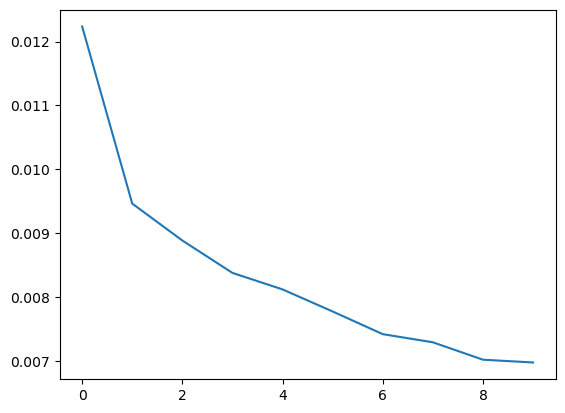

In [56]:
%matplotlib inline
train_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, with_test_data=True, train_data_percentage=0.8)
seqModel = GRURegressionWithAttention(17, hidden_size, 61).to(device)
seqModel.apply(init_weights)
start_time = time.time()
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
train(train_dataloader, seqModel, 10, print_every=1, plot_every=1)
print("--- %s seconds ---" % (time.time() - start_time))

In [62]:
%matplotlib inline

def evaluate01(model, test_data):
    model.eval()
    total_loss = 0
    plot_loss = []
    criterion = nn.MSELoss()
    predictions = []
    with torch.no_grad():
        for inp, tgt, lengths in test_data:
            output = model(inp, tgt)
            pred = torch.nn.utils.rnn.unpad_sequence(output, lengths)
            target_tensor = torch.nn.utils.rnn.unpad_sequence(tgt, lengths, batch_first=True)
            val_loss = 0
            for p, t in zip(pred, target_tensor): 
                val_loss += criterion(
                    p.view(-1),
                    t.view(-1)
                )
            total_loss += val_loss.item()
            plot_loss.append(val_loss.item())
            predictions.append((output, inp, lengths))
    print(f'mean  MSE Loss: {total_loss/len(plot_loss)}')
    plt.plot(np.arange(0, len(plot_loss)*batch_size, batch_size), plot_loss)
    return predictions


def evaluate03(model, test_data):
        model.eval()
        total_loss = 0
        plot_loss = []
        criterion = nn.MSELoss()
        predictions = []
        with torch.no_grad():
            for inp, tgt, sequence_lengths in test_data:
                packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=sequence_lengths)
                output = model(packed_inputs)
                val_loss = criterion(output.view(-1), tgt.view(-1))
                total_loss += val_loss.item()
                plot_loss.append(val_loss.item())
                #Predictions is a list of tuples, output has the shape L*Batch*blendshape counts, sequence lengths will be useful to cut script values
                predictions.append((output, inp, sequence_lengths))
        print(f'mean  MSE Loss: {total_loss/len(plot_loss)}')
        return predictions

def infer(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        return output


557 140
mean  MSE Loss: 0.007445484832195299
--- 17.450531244277954 seconds ---


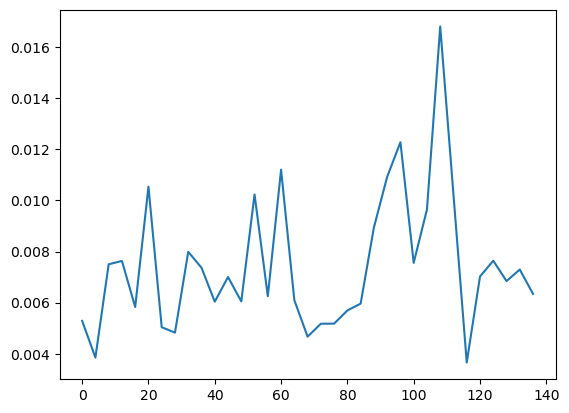

In [63]:
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

start_time = time.time()
predictions = evaluate01(seqModel, test_dataloader)
print("--- %s seconds ---" % (time.time() - start_time))

In [67]:
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

def reconstruct_output(list_of_pred):
    inp_and_out = []
    for pred, inp, l in list_of_pred:
        pred = torch.nn.utils.rnn.unpad_sequence(pred, l)
        inp = torch.nn.utils.rnn.unpad_sequence(inp, l)
        for p1, p2 in zip(inp, pred):
            inp_and_out.append((p1, p2))
    return inp_and_out

inp_and_out = reconstruct_output(predictions)
dic = get_au_dictionary(dataset)

In [16]:
torch.set_printoptions(precision=6)

np.set_printoptions(threshold=sys.maxsize)
for inp, pred in inp_and_out:
    np_array = inp.cpu().data.numpy()
    keys = [k for k, v in dic.items() if v.to_numpy().shape == np_array.shape and np.allclose(v.to_numpy(), np_array, atol=0.00001)]
    print(keys)


NameError: name 'sys' is not defined

In [68]:
import os

def save_results(dataframe, inp_and_out, dic):
    for au, pred in inp_and_out:
        au_np = au.cpu().data.numpy()
        keys = [k for k, v in dic.items() if v.to_numpy().shape == au_np.shape and np.allclose(v.to_numpy(), au_np, atol=0.00001)]
        columns = dataframe.columns[-61:]
        df = pd.DataFrame(columns=columns, data=pred.cpu().data.numpy())
        df.to_csv("predictions/model0.6_pred_low/"+'_pred_'+keys[0]+'.csv', index=False)

def save_individual_csv_by_intensity_type(input_df, folder_path):
    columns = input_df.columns[-61:]
    groups = input_df.groupby('script_id').groups
    for script_id, idx in groups.items():
        full_df = input_df.iloc[idx]
        bs = full_df.iloc[:, -61:]
        df = pd.DataFrame(columns=columns, data=bs)
        full_path = os.path.join(path, "..", "individual_after_preprocessing", folder_path)
        full_path = os.path.normpath(full_path) #allows to use ".." in full path to go up one directory
        df.to_csv(full_path + '/' +  script_id + '.csv', index=False)

save_results(dataset, inp_and_out, dic)

In [69]:
torch.save(seqModel, "model_0.6.pth")